In [1]:
# Import and set up basic packages
import numpy as np

import pandas as pd
pd.options.mode.copy_on_write = True

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 10}) #Basic set up of matplotlib figure and font's size
plt.rcParams["figure.figsize"] = [10, 7]

# Import tools
import joblib
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

# Import models
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', ValueWarning)


# Import Data

In [2]:
# Create a wrangle function
def wrangle(filepath):
    # Read data from csv file
    df = pd.read_csv(filepath, index_col='Month')

    #Tranform the month column 
    df.index = pd.DatetimeIndex(df.index)

    return df

In [3]:
# Wrangle data from the dataset
df = wrangle('/Data analytics/Projects for portfolio/Air Passenger Time series Python/AirPassengers.csv')

# Explore

In [4]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
df['#Passengers'].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Series name: #Passengers
Non-Null Count  Dtype
--------------  -----
144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [6]:
df.isna().sum()

#Passengers    0
dtype: int64

In [7]:
df.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [8]:
len(df)

144

<Axes: >

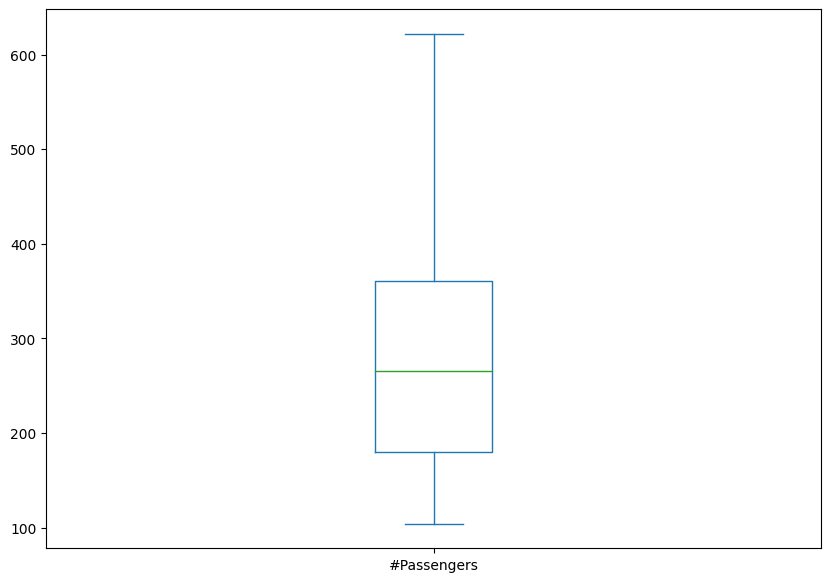

In [9]:
# Box plot
df['#Passengers'].plot(kind='box')

The data doesn't seem to have extreme values/outliers.

<Axes: xlabel='Date'>

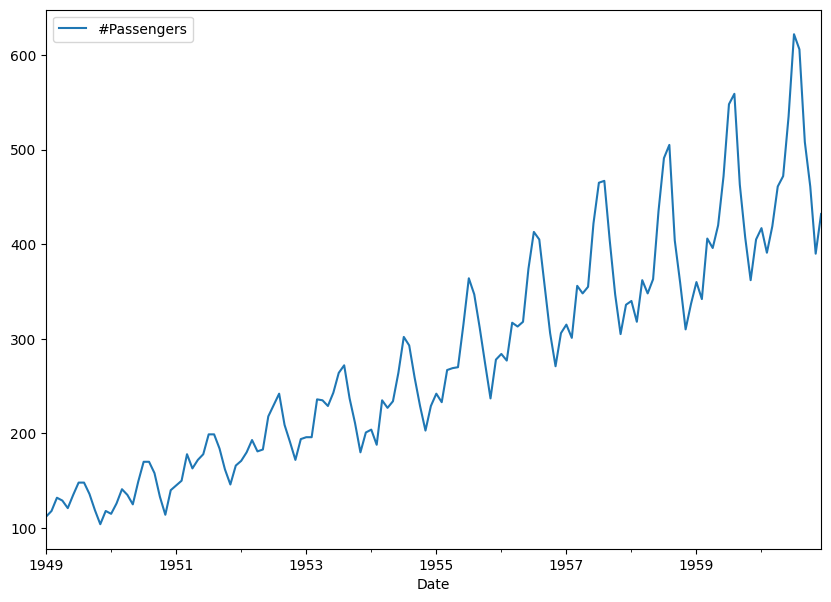

In [10]:
df.plot(xlabel='Date')

<Axes: xlabel='Date'>

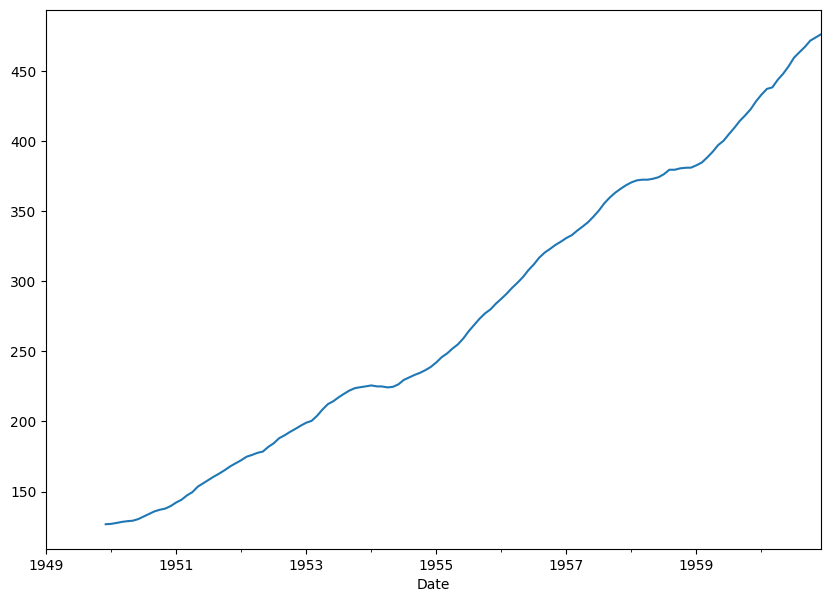

In [11]:
df['#Passengers'].rolling(12).mean().plot(xlabel='Date')

First-look:
* There seems to be a pattern that repeats annually and an upward trend
* Our data is not stationary (changing mean, changing variance)
* The data is showing heteroscedasticity (the standard deviation is not constant), which makes linear regression a bad choice of model.

We will delve deeper later.

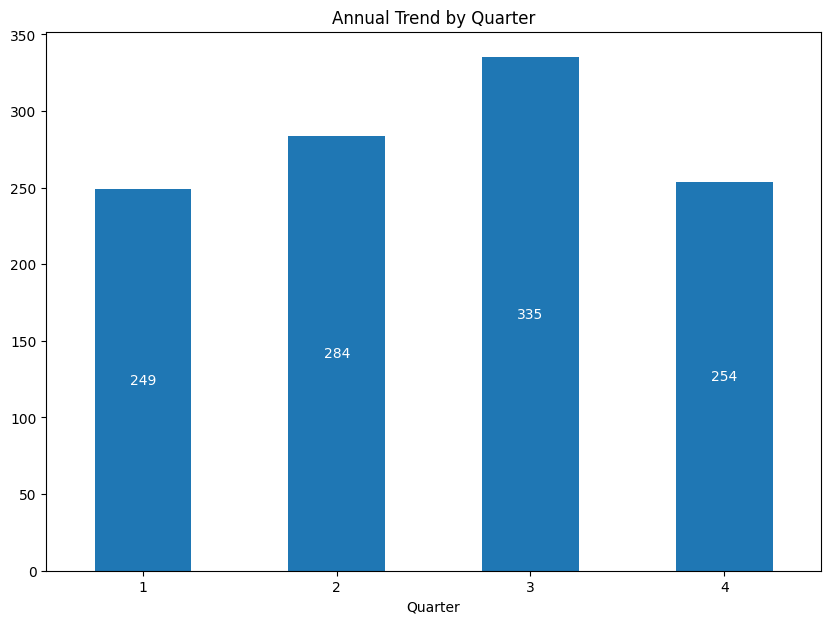

In [12]:
# Annual trend by quarter
annual_tr_quarter = df['#Passengers'].groupby(df['#Passengers'].index.quarter).mean().round()
atq = annual_tr_quarter.plot(kind = 'bar',
                       xlabel = 'Quarter',
                       title='Annual Trend by Quarter')
plt.bar_label(atq.containers[0], label_type='center', color='white')
plt.xticks(rotation=0);

<Axes: title={'center': 'Annual Trend by Month'}, xlabel='Month'>

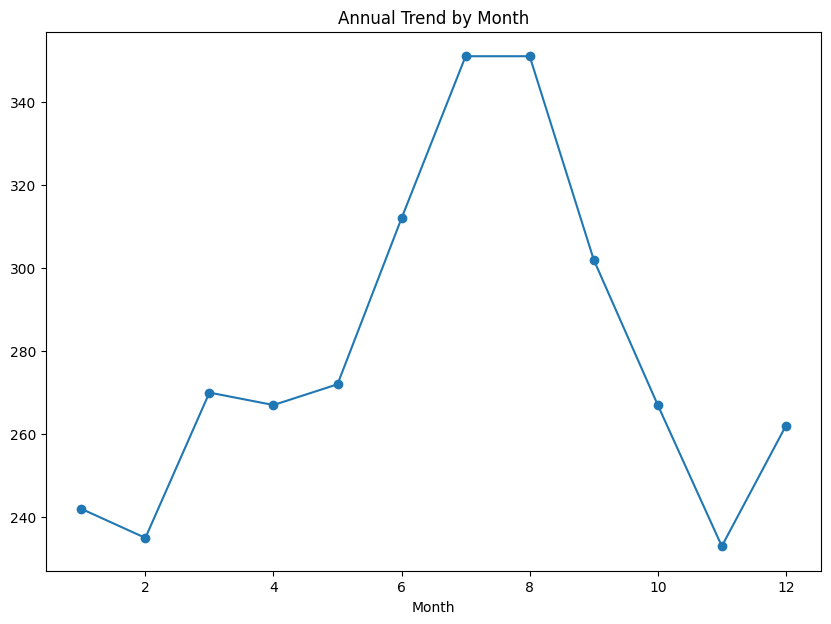

In [13]:
# Annual trend by month
annual_tr_month = df['#Passengers'].groupby(df['#Passengers'].index.month).mean().round()
annual_tr_month.plot(title='Annual Trend by Month', marker='o')

The data follows a general pattern that we usually observe in years that are not influenced by extreme economic conditions, travel restrictions, etc.
* Big spikes in the summer (starting from June to August) due to summer vacations and a high demand for leisure travel:
    * June marks the beginning of the vacation season
    * July is peak travel month
    * The end of August is when the vacation season starts to end for many people
* There are also small spikes:
    * March is when students and families have trips due to students having Spring break
    * December is the holiday season with Christmas at the end of the month and New Year's right after

In [14]:
# Create a function to decompose time-series dataframe
def decomposer(ts_dataframe):
    decompose = seasonal_decompose(ts_dataframe, model='additive')
    fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10, 7))
    decompose.observed.plot(ylabel='Observed', ax=ax[0])
    decompose.trend.plot(ylabel='Trend', ax=ax[1])
    decompose.seasonal.plot(ylabel='Seasonal', ax=ax[2])
    decompose.resid.plot(ylabel='Resid', ax=ax[3])
    
    plt.xlabel('Date')

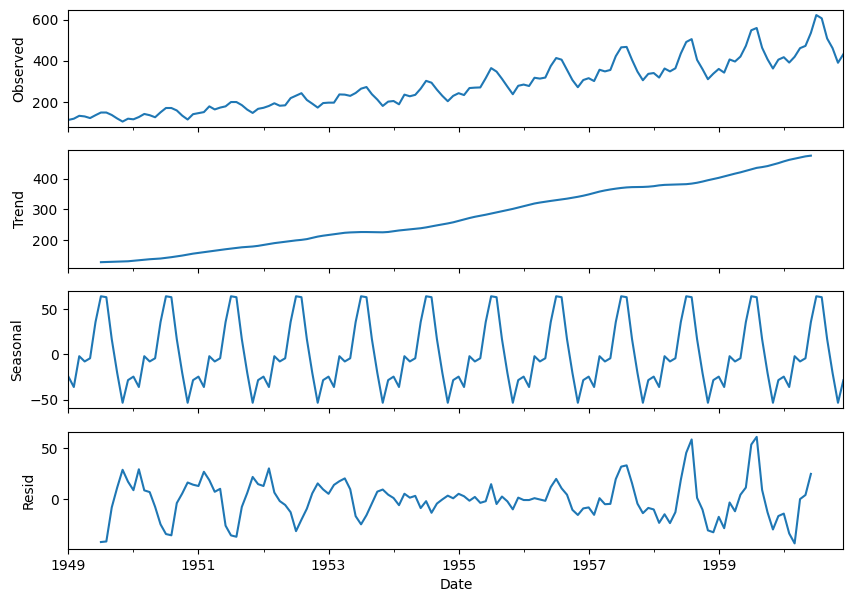

In [15]:
# Decompose our time series
decomposer(df)

A few things that we can draw from the decomposer:
* There is a noticable upward trend
* There is seasonality, which will make SARIMA a better choice than ARIMA
* Residual plot doesn't show any trend or seasonality, so the decomposer is working fine

In [16]:
# First-order differencing
diff_1 = df.diff(1).fillna(0)

In [17]:
# Create a function to test the stationarity of the time-series
def stationarity_test(series):
    result = adfuller(series)
    p_val = result[1]

    # Interpret test result
    if p_val < 0.05:
        print('The time-series is stationary (reject the null hypothesis).')
    else:
        print('The time-series is non-stationary (fail to reject the null hypothesis).')

In [18]:
# Check first-order stationarity using adfuller
stationarity_test(diff_1['#Passengers'].values)

The time-series is stationary (reject the null hypothesis).


The first difference is stationary and the d parameter is 1.

<Axes: xlabel='Date'>

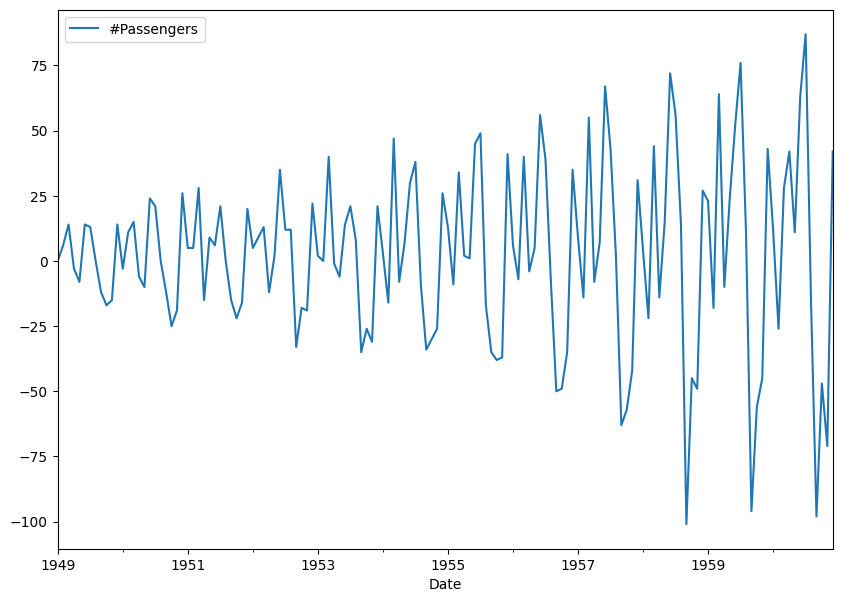

In [19]:
# Plot first difference for visual inspection
diff_1.plot(xlabel='Date')

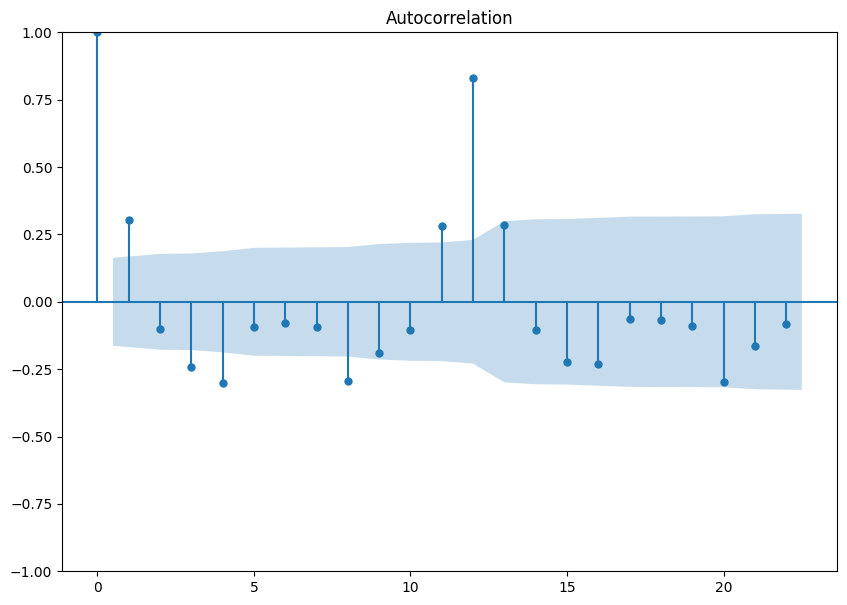

In [20]:
# ACF plot
plot_acf(diff_1);

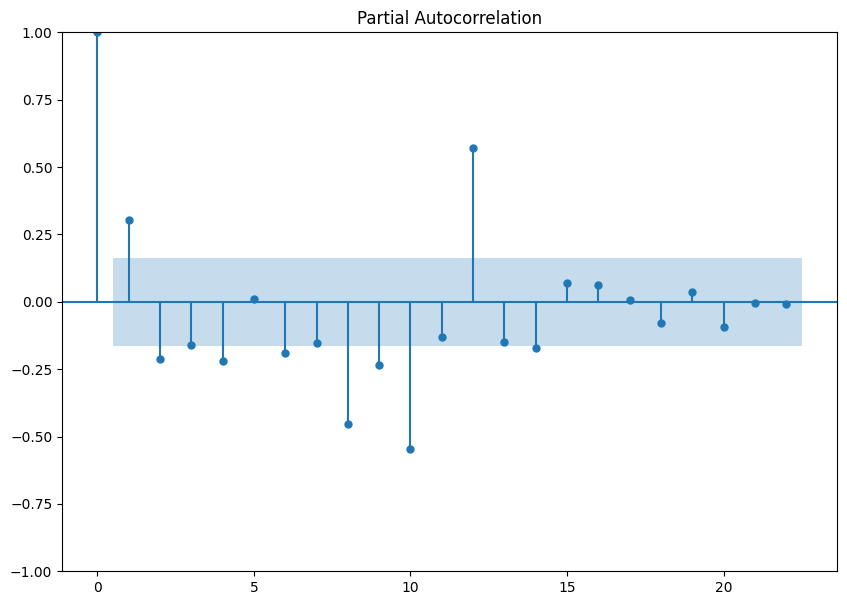

In [21]:
# PACF plot
plot_pacf(diff_1);

A q parameter value of 1 is adequate, whereas a p (lags) parameter should fall within the range of 0 to 3.